In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
# from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv3DTranspose, BatchNormalization, LeakyReLU, concatenate
# from keras.models import Sequential, Model
# from keras.optimizers import Adam

# # Define the input shape
# input_shape = (160, 160, 192, 1)

# # Create a sequential model
# model = Sequential()

# # Add convolutional layers with max pooling
# model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Conv3D(64, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Conv3D(128, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# # Add fully connected layers
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Define the input shape
# img_shape = (160, 160, 192, 2)
# latent_dim = 100

# # Create a generator model
# generator = Sequential()

# generator.add(Dense(128 * 20 * 20 * 24, activation="relu", input_dim=latent_dim))
# generator.add(Reshape((20, 20, 24, 128)))
# generator.add(Conv3DTranspose(128, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding="same"))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(LeakyReLU(alpha=0.2))
# generator.add(Conv3DTranspose(64, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding="same"))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(LeakyReLU(alpha=0.2))
# generator.add(Conv3DTranspose(2, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding="same", activation='tanh'))

# # Create a discriminator model
# discriminator = Sequential()

# discriminator.add(Conv3D(32, kernel_size=(3, 3, 3), strides=(2, 2, 2), input_shape=img_shape, padding="same"))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.25))
# discriminator.add(Conv3D(64, kernel_size=(3, 3, 3)))


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import nibabel as nib
import numpy as np
from tqdm import tqdm
from torchvision.transforms import Compose

In [54]:
# Custom dataset class for handling NIfTI files
class BrainDataset(Dataset):
    def __init__(self, t1w_files, t2w_files, fa_files, adc_files, transform=None):
        self.t1w_files = t1w_files
        self.t2w_files = t2w_files
        self.fa_files = fa_files
        self.adc_files = adc_files
        self.transform = transform

    def __len__(self):
        return len(self.t1w_files)

    def __getitem__(self, idx):
        t1w_image = nib.load(self.t1w_files[idx]).get_fdata()
        #print("t1w", t1w_image.shape)
        t2w_image = nib.load(self.t2w_files[idx]).get_fdata()
        #print("t2w", t2w_image.shape)
        fa_image = nib.load(self.fa_files[idx]).get_fdata()
        adc_image = nib.load(self.adc_files[idx]).get_fdata()

        input_image = np.stack([t1w_image, t2w_image], axis=0)
        #print("input image", input_image.shape)
        target_image = np.stack([fa_image, adc_image], axis=0)
        #print("target image", target_image.shape)

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

In [16]:
cd ..

c:\Users\keert\project2\data


In [19]:
pwd

'c:\\Users\\keert\\project2\\data\\input'

In [55]:
# root_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
#os.chdir(root_dir)
# Change the working directory to the "data" folder
# os.chdir('./data/output')
# os.chdir('./input')
# data_dir = os.path.join(root_dir, 'data')

patient_folders = [folder for folder in os.listdir() if os.path.isdir(folder) and folder.startswith('0')]

t1w_files = []
t2w_files = []
fa_files = []
adc_files = []

for patient_folder in patient_folders:
    path = os.path.join(patient_folder, patient_folder,)

    t1w_files.append(os.path.join(path, "T1w_1mm.nii.gz"))
    t2w_files.append(os.path.join(path, "T2w_1mm_noalign.nii.gz"))
    adc_files.append(os.path.join(path, "ADC_deformed.nii.gz"))
    fa_files.append(os.path.join(path, "FA_deformed.nii.gz"))

    # registered_path = os.path.join(patient_folder, patient_folder, 'registered')
    # normalized_path = os.path.join(patient_folder, patient_folder, 'normalized')

    # t1w_files.append(os.path.join(normalized_path, "T1w_1mm_normalized.nii.gz"))
    # t2w_files.append(os.path.join(registered_path, "T2w_registered.nii.gz"))
    # adc_files.append(os.path.join(registered_path, "ADC_registered.nii.gz"))
    # fa_files.append(os.path.join(registered_path, "FA_registered.nii.gz"))

dataset = BrainDataset(t1w_files, t2w_files, fa_files, adc_files, transform=Compose([torch.tensor]))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True) #, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 0 for FA, 1 for ADC
output_modality = 0

In [25]:
print(t1w_files)

['001\\001\\T1w_1mm.nii.gz', '002\\002\\T1w_1mm.nii.gz', '003\\003\\T1w_1mm.nii.gz', '004\\004\\T1w_1mm.nii.gz']


In [56]:
for inputs, targets in tqdm(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        print(inputs.shape)
        print(targets.shape)

 50%|█████     | 1/2 [00:01<00:01,  1.50s/it]

torch.Size([2, 2, 182, 218, 182])
torch.Size([2, 2, 145, 174, 145])


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

torch.Size([2, 2, 182, 218, 182])
torch.Size([2, 2, 145, 174, 145])


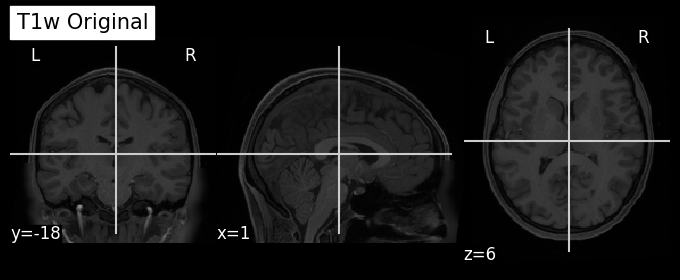

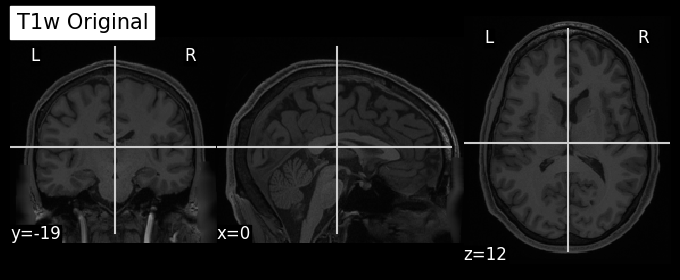

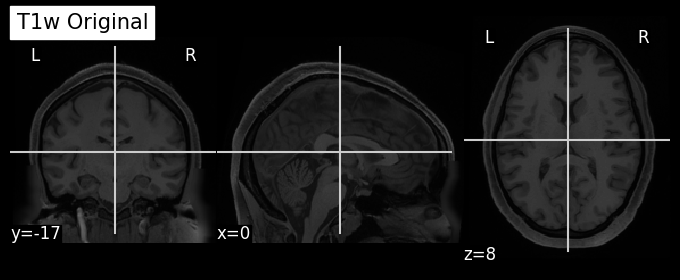

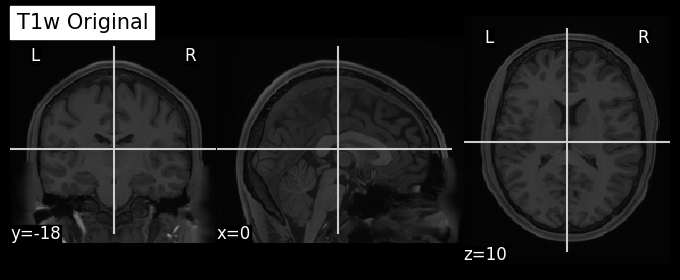

In [26]:
from nilearn import plotting
import matplotlib
import matplotlib.pyplot as plt
import nibabel as nib

def display_image(input_image_file, title):
    """
    Display NIfTI image using nilearn.
    
    Args:
        input_image_file (str): Path to the original NIfTI file.
        output_image_file (str): Path to the skull-stripped NIfTI file.
        title (str): Title of the plot.
    """
    plotting.plot_anat(input_image_file, title=title + " Original", display_mode='ortho')
    plotting.show()

for file in t1w_files:
    display_image(file,'T1w')

In [30]:
input_shape = (1, 182, 218, 182)

nc = 1 # num channels

ngf = 32 # size of feature maps in generator

ndf = 32 # size of feature maps in discriminator

num_epochs = 1 # 200

lr = 0.0002

betas = (0.5, 0.999) # beta1 hyperparameter for Adam optimizers

ngpu = 1 # number of GPUs available, 0 for CPU mode

batch_size = 128 # batch size during training

latent_dim = 100

ngpu = 0 # Number of GPUs available. Use 0 for CPU mode.

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [31]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.convnet = nn.Sequential(
            # input is 1 x 182 x 218 x 182
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            # input is 32 x 91 x 109 x 91
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            # input is 64 x 46 x 55 x 46
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1),
            nn.MaxPool3d(kernel_size=(2, 2, 2)),
            # input is 128 x 23 x 28 x 23
            nn.Linear(128 * 23 * 28 * 23, latent_dim),
            nn.BatchNorm3d(latent_dim),
            nn.LeakyReLU()
            # nn.Linear(128, 64),
            # nn.Linear(64, 1),
            # nn.ReLU(),
            # nn.Sigmoid(), # is this needed?
        )

    def forward(self, x):
        return self.convnet(x)

In [33]:
t1_model = ConvNet()
t2_model = ConvNet()

# custom weights initialization called on netG and netD
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

# randomly initializing weights
# t1_model.apply(weights_init)
# t2_model.apply(weights_init)

In [34]:
# Define the input shape
img_shape = (2, 182, 218, 182)

# Define the generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc_layer = nn.Sequential(
            nn.Linear(latent_dim * 2, 128 * 23 * 28 * 23),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d( 128 * 23 * 28 * 23)
        )
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose3d(32, 2, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1)),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc_layer(x)
        x = x.view(x.shape[0], 128, 23, 28, 23) # reshaping tensor
        x = self.conv_layers(x)
        return x

In [35]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.Dropout3d(0.25),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            #nn.Dropout3d(0.25),
            nn.Flatten(),
            # nn.Linear(64 * 23* 28 * 23, 128),
            # nn.LeakyReLU(0.2), #inplace=True
            # nn.Linear(128, 64),
            # nn.LeakyReLU(0.2), #inplace=True
            # nn.Linear(64, 1),
            nn.Linear(64 * 23 * 28 * 23, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

In [36]:
# Create the discriminator and generator models
discriminator = Discriminator()
generator = Generator()

# generator.apply(weights_init)
# discriminator.apply(weights_init)

# Define the loss function and optimizer for the discriminator and generator
adversarial_loss = nn.BCELoss()
generative_loss = nn.MSELoss()
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_T1 = torch.optim.Adam(t1_model.parameters(), lr=lr*10, betas=betas)
optimizer_T2 = torch.optim.Adam(t2_model.parameters(), lr=lr*10, betas=betas)

# Define the input shape for the real and fake images
# real_imgs = torch.zeros((32, *input_shape))
# fake_imgs = torch.zeros((32, latent_dim))

In [44]:
## Change to True / False if you do / do not want 
## to load the previously saved state dictionaries
load = False
if load:
    generator.load_state_dict(torch.load("generator.pt"))
    discriminator.load_state_dict(torch.load("discriminator.pt"))

img_list = []
G_losses = []
D_losses = []
iters = 0

# Train the models
for epoch in range(num_epochs):
    # # Train the discriminator
    # optimizer_D.zero_grad()
    i = 0
    for inputs, targets in tqdm(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        print(targets.shape)
        
        # update D: maximize log(D(x)) + log(1 - D(G(z)))
        # train with all-real batch
        discriminator.zero_grad()
        real_image = targets[output_modality]
        real_label = torch.ones(real_image.shape[0], 1)#.cuda()
        real_prediction = discriminator(real_image)
        real_loss = adversarial_loss(real_prediction, real_label)
        real_loss.backward()

        # create latent space and update D with fake image
        t1_latent = t1_model(inputs[0]) 
        t2_latent = t2_model(inputs[1])
        # TODO: change to concat
        # latent = t1_latent + t2_latent
        latent = torch.concat((t1_latent, t2_latent), 0) # might have to change 0 to 1
        fake_image = generator(latent)
        fake_labels = torch.zeros(fake_image.shape[0], 1)#.cuda()
        fake_predictions = discriminator(fake_image.detach())
        fake_loss = adversarial_loss(fake_predictions, fake_labels)
        fake_loss.backward()

        discriminator_loss = real_loss + fake_loss
        optimizer_D.step()

        # update G network: maximize log(D(G(z)))
        generator.zero_grad()
        t1_model.zero_grad()
        t2_model.zero_grad()

        fake = generator(latent)
        fake_prediction = discriminator(fake)
        errG = adversarial_loss(fake_prediction, real_label)
        errR = generative_loss(fake, targets[output_modality])
        generator_loss = errG + errR
        generator_loss.backward()
        optimizer_G.step()     
        optimizer_T1.step()
        optimizer_T2.step()   

        # output training stats
        #if i % 50 == 0:
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())

        # Print the losses
        if i % 100 == 0:
            print("Epoch [%d/%d], Step [%d/%d], Discriminator Loss: %.4f, Generator Loss: %.4f"
                  % (epoch, num_epochs, i, len(dataloader), discriminator_loss.item(), generator_loss.item()))
            torch.save(generator.state_dict(), "generator.pt")
            torch.save(discriminator.state_dict(), "discriminator.pt")
        i += 1
            
        iters += 1

  0%|          | 0/2 [00:01<?, ?it/s]

torch.Size([2, 2, 145, 174, 145])


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3, 3], expected input[1, 2, 145, 174, 145] to have 1 channels, but got 2 channels instead

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()